In [1]:
# Add the path to the Utils folder
import sys
import tensorflow as tf
sys.path.append('../Utils')

from tensorflow import keras
from deeplabV3Utils import load_data, DeeplabV3Plus, plot_metrics, evaluate_model_on_folder, visualize_images

# Trying different network architecture - DeepLabV3



## Loading Data

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 1
NUM_CLASSES = 5

train_sat_folder = "./../Data_filtered_80_resampled_128_LANCZOS/train/sat/"
train_gt_folder = "./../Data_filtered_80_resampled_128_LANCZOS/train/gt/"

#train_sat_folder = "./../Data_filtered_80_resampled_128_LANCZOS/validate/sat/"
#train_gt_folder = "./../Data_filtered_80_resampled_128_LANCZOS/validate/gt/"

val_sat_folder = "./../Data_filtered_80_resampled_128_LANCZOS/validate/sat/"
val_gt_folder = "./../Data_filtered_80_resampled_128_LANCZOS/validate/gt/"

In [60]:
# Load and preprocess the training dataset
X_train, y_train = load_data(train_sat_folder, train_gt_folder, NUM_CLASSES, BATCH_SIZE)

# Load and preprocess the validation dataset
X_val, y_val = load_data(val_sat_folder, val_gt_folder, NUM_CLASSES, BATCH_SIZE)

Loading batches: 100%|██████████| 607/607 [00:01<00:00, 418.53batch/s]


## DeepLabV3_plus architecture

In [61]:
model_deeplabv3 = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model_deeplabv3.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem_6  (None, 128, 128, 3)          0         ['input_7[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 tf.nn.bias_add_6 (TFOpLamb  (None, 128, 128, 3)          0         ['tf.__operators__.getitem_6[0
 da)                                                                ][0]']                        
                                                                                            

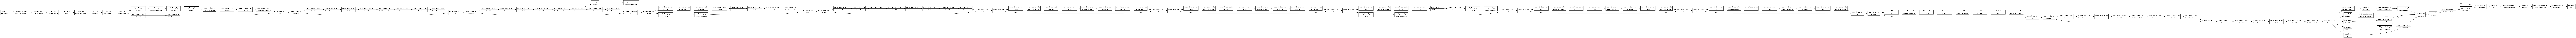

In [62]:
keras.utils.plot_model(
    model_deeplabv3,
    to_file="model_deeplabv3.png",
    #show_shapes=True,
    #show_dtype=True,
    #show_layer_names=True,
    rankdir="LR",  # horizontal layout
    #rankdir="TB", # vertical layout
    #expand_nested=False,
    #dpi=200,
    #show_layer_activations=True,
    #show_trainable=True
)


## DeepLabV3_plus model training

In [63]:
# warning: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of ... exceeds 10% of free system memory.
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   /  #os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
# adding steps_per_epoch=STEPS_PER_EPOCH to model.fit method
#STEPS_PER_EPOCH = 3000
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.CategoricalCrossentropy(name='cat_cross_entropy'),
      #keras.metrics.MeanIoU(name='mIoU', num_classes=NUM_CLASSES),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [65]:
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = tf.compat.v1.losses.sparse_softmax_cross_entropy
#loss = keras.losses.sparse_categorical_crossentropy(
#    from_logits=False, ignore_class='0', axis=-1
#)
loss = "categorical_crossentropy"
model_deeplabv3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0),
    loss=loss,
    #metrics=["accuracy"],
    metrics=METRICS,
)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'deeplabv3_model_{epoch:02d}_{val_accuracy:.3f}.keras',
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,
    save_weights_only=False,  # Save entire model
    mode='max',  # Save the model with the highest validation accuracy
    #verbose=1
    verbose=0
)

model_history = model_deeplabv3.fit(X_train, y_train,
                          epochs=10,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_val, y_val),
                          #class_weight=class_weight_dict,
                          #steps_per_epoch=STEPS_PER_EPOCH,
                          #callbacks=[checkpoint]
)

Epoch 1/10
4618/4618 [==============================] - 1334s 286ms/step - loss: 1.2769 - cross entropy: 5.0281 - cat_cross_entropy: 1.2769 - Brier score: 176.1930 - tp: 19620608.0000 - fp: 74561280.0000 - tn: 228083904.0000 - fn: 56040672.0000 - accuracy: 0.6548 - precision: 0.2083 - recall: 0.2593 - auc: 0.5033 - prc: 0.2054 - val_loss: 1.1959 - val_cross entropy: 5.0138 - val_cat_cross_entropy: 1.1959 - val_Brier score: 228.7933 - val_tp: 3596429.0000 - val_fp: 11374367.0000 - val_tn: 28405992.0000 - val_fn: 6348659.0000 - val_accuracy: 0.6436 - val_precision: 0.2402 - val_recall: 0.3616 - val_auc: 0.5372 - val_prc: 0.2275
Epoch 2/10
4618/4618 [==============================] - 1319s 286ms/step - loss: 1.1806 - cross entropy: 6.5851 - cat_cross_entropy: 1.1806 - Brier score: 439.3306 - tp: 32217720.0000 - fp: 124919072.0000 - tn: 177726224.0000 - fn: 43443644.0000 - accuracy: 0.5550 - precision: 0.2050 - recall: 0.4258 - auc: 0.5066 - prc: 0.2051 - val_loss: 1.0362 - val_cross entro

In [71]:
# Save the trained model
model_deeplabv3.save("deeplabv3_model.h5")

d:\GIT\ML_Zoomcamp_2023_Capstone2_Project\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


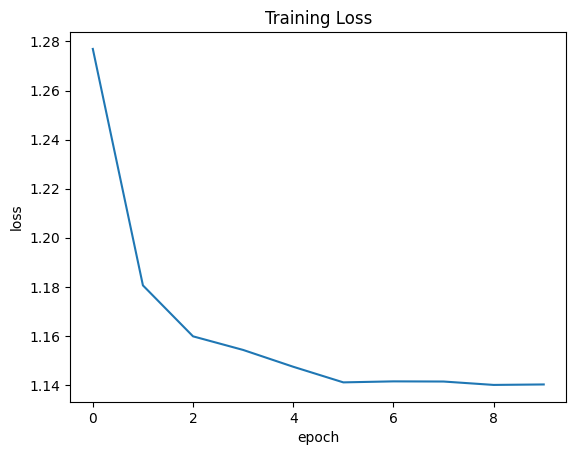

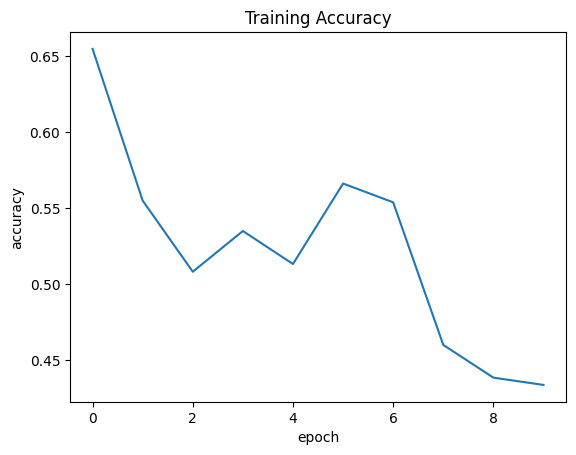

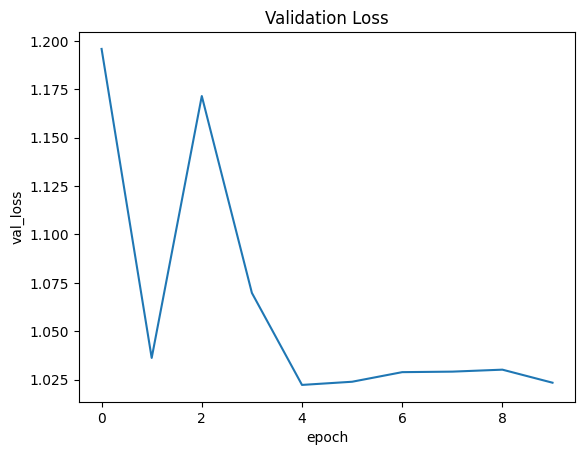

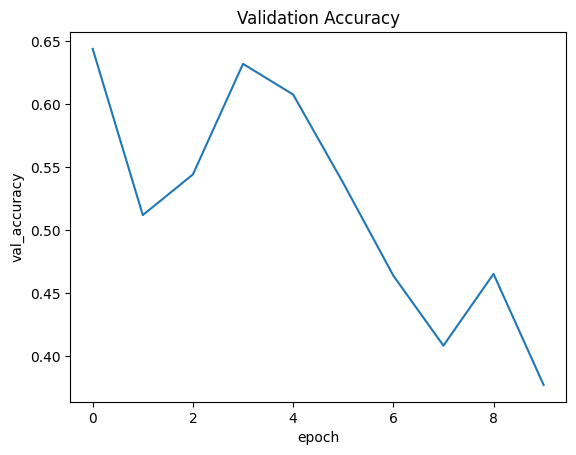

In [68]:
plt.plot(model_history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(model_history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

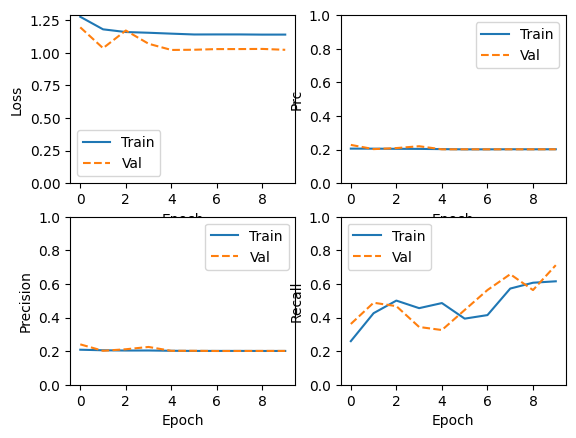

In [69]:
plot_metrics(model_history)

19/19 [==============================] - 26s 1s/step


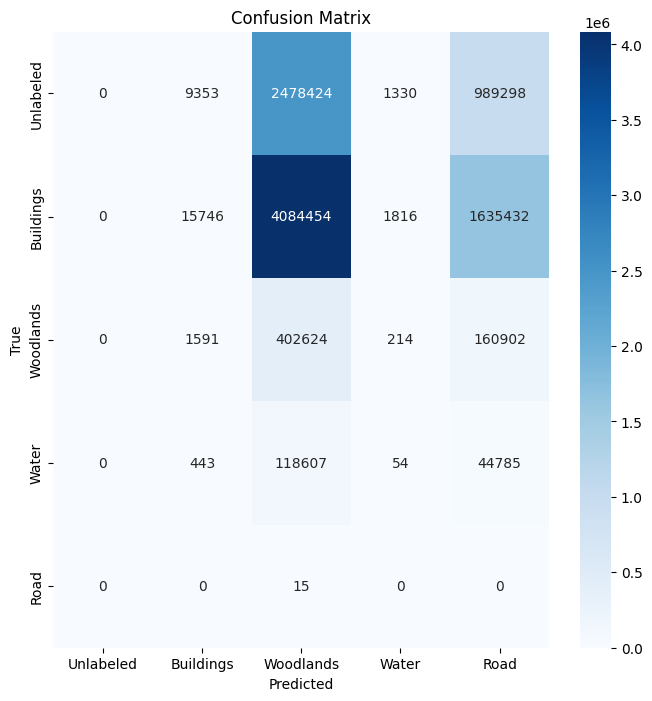

Classification Report:


d:\GIT\ML_Zoomcamp_2023_Capstone2_Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\GIT\ML_Zoomcamp_2023_Capstone2_Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Unlabeled       0.00      0.00      0.00   3478405
   Buildings       0.58      0.00      0.01   5737448
   Woodlands       0.06      0.71      0.11    565331
       Water       0.02      0.00      0.00    163889
        Road       0.00      0.00      0.00        15

    accuracy                           0.04   9945088
   macro avg       0.13      0.14      0.02   9945088
weighted avg       0.34      0.04      0.01   9945088



d:\GIT\ML_Zoomcamp_2023_Capstone2_Project\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
model_path = "./../Model/deeplabv3_model.h5"
model_deeplabv3 = keras.models.load_model(model_path)

evaluate_model_on_folder(model_deeplabv3, val_sat_folder, val_gt_folder, (IMAGE_SIZE, IMAGE_SIZE))

1/1 [==============================] - 1s 916ms/step


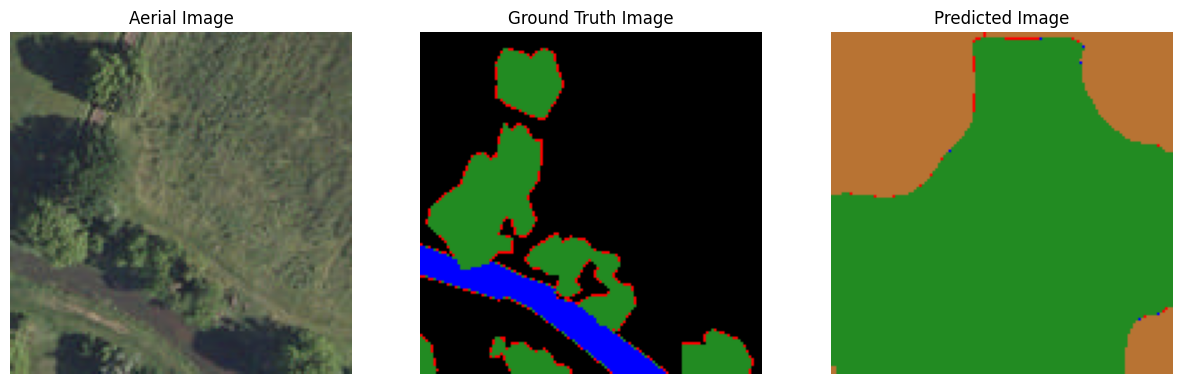

1/1 [==============================] - 1s 900ms/step


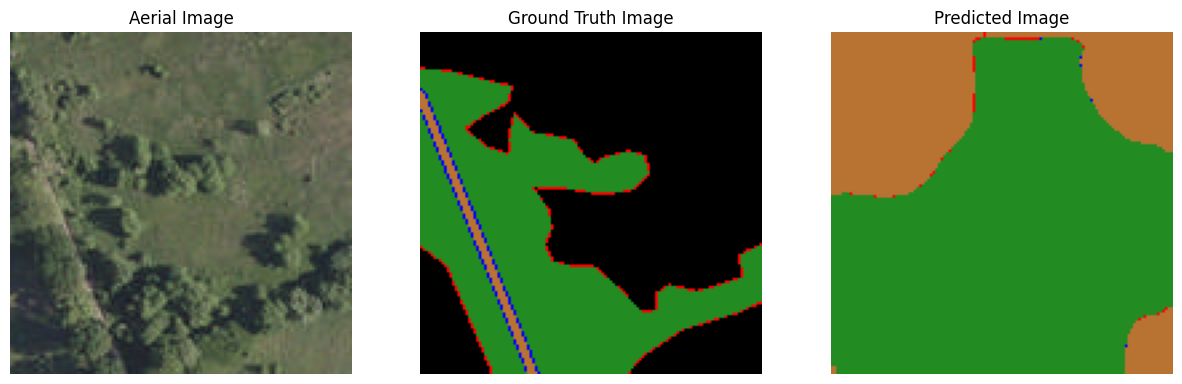

1/1 [==============================] - 1s 921ms/step


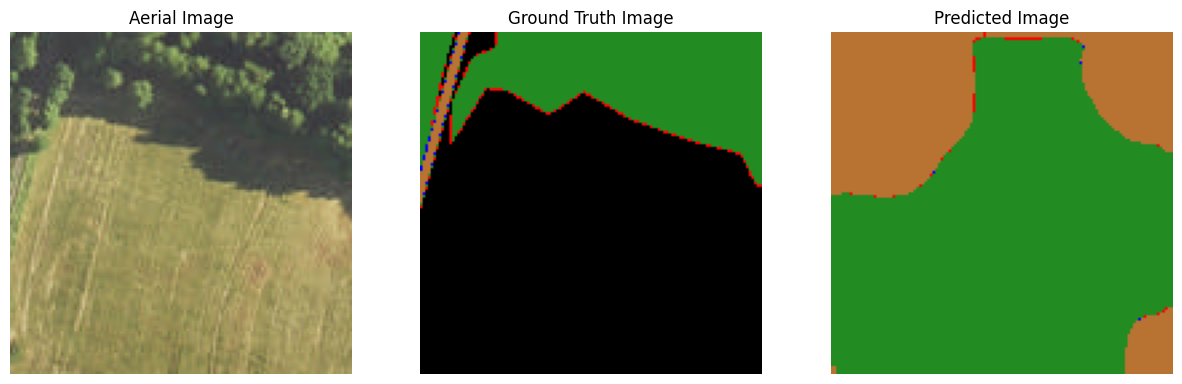

1/1 [==============================] - 1s 937ms/step


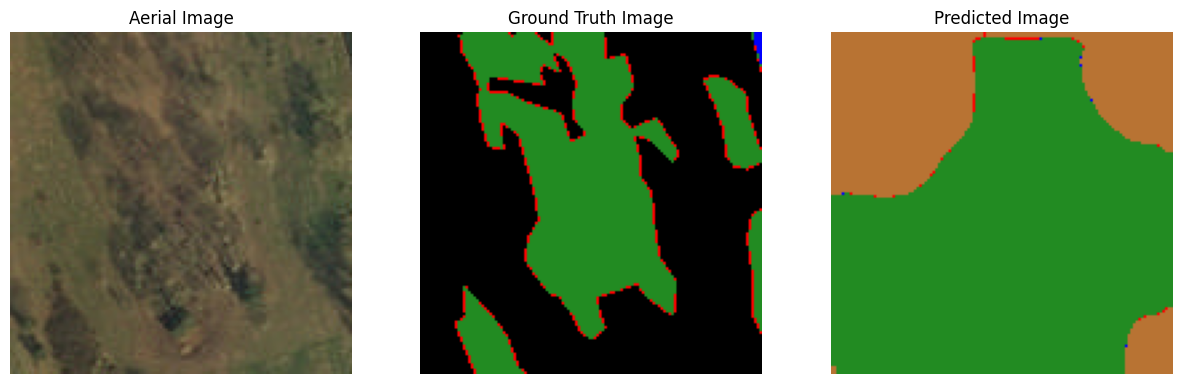

1/1 [==============================] - 1s 916ms/step


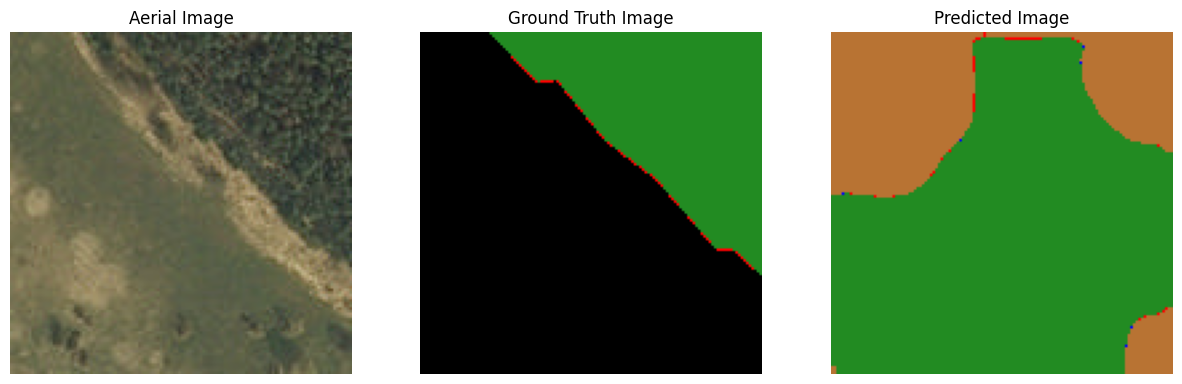

In [6]:
model_path = "./../Model/deeplabv3_model.h5"
model = keras.models.load_model(model_path)
visualize_images(val_sat_folder, val_gt_folder, model_path=model_path, num_samples=5)